### FasterRCNN

In this tutorial, we will apply region based object detection model, FasterRCNN, to detect object in sky survey images.


Exercises

- Explore FasterRCNN model

- load dataset

- train the model

- make predictions and evaulation


In [1]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [ ]:
cd '/drive/MyDrive/ztf_summer_school_2025/day4/le_study/'

In [12]:
!pip install torch==2.1 torchvision==0.16 numpy==1.25.2
# com https://github.com/pytorch/vision

# due to incompatible issues, we need to downgrade pytorch to 2.1 and torchvision to 0.16, numpy to 1.25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.2 which is incompatible.
xarray 2025.7.1 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.2 which is incompatible.
tensorflow 2.18.0 requires num

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms, datasets
from torchsummary import summary
from PIL import Image

In [4]:
torch.__version__, torchvision.__version__

('2.1.0+cu121', '0.16.0+cu121')

In [5]:
np.__version__

'1.25.2'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### explore model

We will load the pretrained model on the COCO datasets from torchvision

The FasterRCNN model has three major parts
- backbone: feature extraction
- rpn: region proposal network,
- roi_head: classification and bounding box regression

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')



In [17]:
model.backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): C

In [18]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [19]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

In [8]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### eval mode

eval mode, the model take list of images as input, and predict class and

In [9]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [10]:
x = torch.rand(3, 300, 400)
x = x.to(device)
#x = x.unsqueeze(0)
x.shape

torch.Size([3, 300, 400])

In [11]:
predictions = model([x])

In [12]:
predictions

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]

### train mode

train mode, the model images and targets as input, and output loss

FasterRCNN contains 4 loss
- loss_objectness
- loss_rpn_box_reg
- loss_classifier
- loss_box_reg


In [ ]:
model.train()

In [14]:

# 4 images, each image has 11 boxes [x1, y1, x2, y2]; label
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)

boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
labels = torch.randint(1, 91, (4, 11))



In [15]:
images.shape, labels

(torch.Size([4, 3, 600, 1200]),
 tensor([[54, 26, 21, 20, 61, 25, 42,  7, 77, 82, 48],
         [86, 58, 78, 59, 61, 24, 43, 51, 80, 87, 83],
         [57, 56,  7, 54, 60, 29, 18, 79, 58, 29, 62],
         [11, 47, 88, 69, 76, 69, 61,  6, 66, 52,  9]]))

In [16]:
images = list(image.to(device) for image in images)

targets = []

for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i].to(device)
    d['labels'] = labels[i].to(device)
    targets.append(d)


In [18]:
type(images), images[0].shape, len(images)

(list, torch.Size([3, 600, 1200]), 4)

In [19]:
type(targets), targets[0], len(targets)

(list,
 {'boxes': tensor([[0.7004, 0.9047, 0.7643, 1.7092],
          [0.8477, 0.2749, 1.7428, 0.8306],
          [0.4817, 0.9654, 0.9267, 1.4261],
          [0.8233, 0.9491, 1.2537, 1.2924],
          [0.9813, 0.5344, 1.5813, 0.6165],
          [0.5609, 0.1179, 1.5211, 0.9420],
          [0.2332, 0.4580, 0.4558, 0.7200],
          [0.4758, 0.5950, 1.3849, 0.7611],
          [0.8600, 0.9717, 1.4198, 1.9158],
          [0.2151, 0.7944, 0.7992, 1.3539],
          [0.0948, 0.3108, 0.1632, 0.6222]], device='cuda:0'),
  'labels': tensor([54, 26, 21, 20, 61, 25, 42,  7, 77, 82, 48], device='cuda:0')},
 4)

In [20]:
# in train mode

output = model(images, targets)

In [21]:
######
#output loss

output


{'loss_classifier': tensor(0.3994, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0265, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(2.0376, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(1.1004, device='cuda:0', grad_fn=<DivBackward0>)}

### load dataset

In [22]:
class LEDataset(torch.utils.data.Dataset):
    def __init__(self, annot_path='./dataset/rcnn/LE_train.txt',
                        transform=None):

        self.ann = self.get_annot(annot_path=annot_path)
        self.imgfiles = list( self.ann.keys() )
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.imgfiles[idx]
        img = Image.open(img_path).convert("RGB")

        img = self.transform(img).to(device)

        box_labels  = self.ann[img_path]
        target = {}
        target['boxes'] = torch.from_numpy(box_labels[:, :4]).to(device)
        target['labels'] = torch.from_numpy(box_labels[:, 4] + 1, ).to(torch.int64).to(device)
        return img, target

    def get_annot(self, annot_path = 'train.txt'):
        """get annotation from dataset text"""
        with open(annot_path, 'r') as f:
            txt = f.readlines()
            annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
        resdic = {}
        for ann in annotations:
            ann = ann.split(' ')
            image_path = ann[0]
            boxarr = []
            for a in ann[1:]:
                box = np.fromstring(a, sep=',')
                boxarr.append(box)
            boxarr = np.array(boxarr)
            resdic[image_path] = boxarr

        return resdic

    def __len__(self):
        return len(self.imgfiles)


In [23]:
transform = transforms.Compose([
    transforms.ToTensor()
    ])


In [24]:
leData = LEDataset(annot_path='./dataset/rcnn/LE_train.txt',
                   transform=transform)

data_loader = torch.utils.data.DataLoader(leData, batch_size=2, shuffle=True,
                                          collate_fn=lambda x: tuple(zip(*x)))



In [36]:
len(data_loader)

5

In [25]:
imgs, targets = next(iter(data_loader))

In [26]:
targets[0]['labels']

tensor([1, 1, 1, 1, 1, 2, 2, 2, 2, 2], device='cuda:0')

In [27]:
output = model(imgs, targets)

In [28]:
output

{'loss_classifier': tensor(1.3333, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.3523, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(1.1212, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0702, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)}

### plot boxes

In [29]:
Colors = {1:'indianred', 2: 'steelblue'}

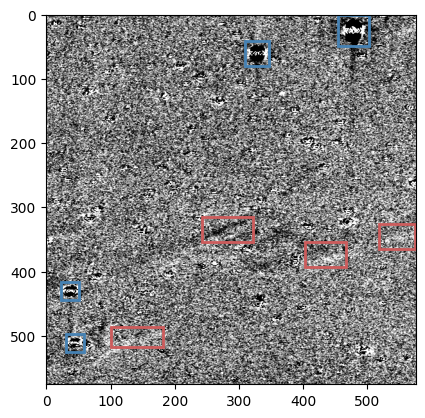

In [30]:
fig, ax = plt.subplots(1, 1)

idx = 1

img = imgs[idx].cpu().numpy();
target = targets[idx]

ax.imshow(img[0, :,:], cmap='gray', )
for i in range(len(target['labels'])):
    xmin, ymin, xmax, ymax = target['boxes'][i].cpu().numpy()
    label = int(target['labels'][i].cpu())
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                    fill=False, color=Colors[label], linewidth=2)

    ax.add_patch(rect)


### train the model

In [78]:
model.train();


In [79]:
params = [p for p in model.parameters() if p.requires_grad]

In [80]:
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)



In [81]:
num_epochs = 40
loss_run = []

for epoch in range(num_epochs):
    for images, targets in data_loader:
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_run.append(losses.item())
        print(f'epoch {epoch}, loss {losses}')


epoch 0, loss 1.0079837751915703
epoch 0, loss 6.501361875292599
epoch 0, loss 11.281112994623484
epoch 0, loss 6.986507948786626
epoch 0, loss 25.57398440881005
epoch 1, loss 2.3543623211297255
epoch 1, loss 1.7199123909653276
epoch 1, loss 1.8800793729755936
epoch 1, loss 1.8058053987717555
epoch 1, loss 0.9167719989700004
epoch 2, loss 1.399357954356258
epoch 2, loss 0.8510982054158804
epoch 2, loss 2.9732875226095388
epoch 2, loss 1.6872532136119032
epoch 2, loss 0.9884594132110591
epoch 3, loss 1.252910760460297
epoch 3, loss 0.6799693396311075
epoch 3, loss 1.0435761679673818
epoch 3, loss 0.864795023922917
epoch 3, loss 0.86310014387315
epoch 4, loss 0.8122336904860257
epoch 4, loss 0.6738648425189186
epoch 4, loss 0.6915894587495856
epoch 4, loss 0.7314603892773398
epoch 4, loss 0.9290106234199169
epoch 5, loss 0.7477969840784008
epoch 5, loss 0.9118587657057807
epoch 5, loss 1.013307890093889
epoch 5, loss 0.9599853918746978
epoch 5, loss 0.7893064029041179
epoch 6, loss 0.632

Text(0, 0.5, 'loss')

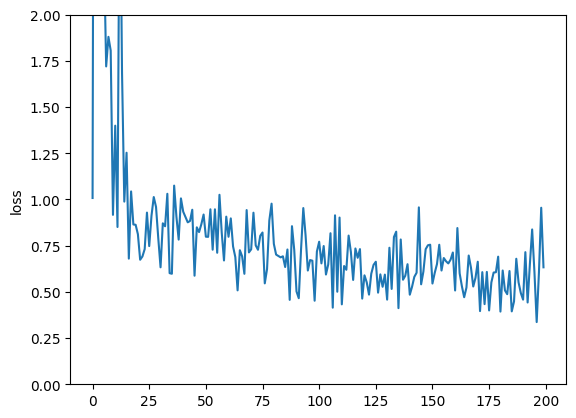

In [82]:
plt.plot(loss_run)
plt.ylim([0, 2])
plt.ylabel('loss')

In [83]:
model.eval();

In [84]:
leData_test = LEDataset(annot_path='./dataset/rcnn/LE_test.txt',
                   transform=transform)

data_loader_test = torch.utils.data.DataLoader(leData_test, batch_size=4, shuffle=True,
                                          collate_fn=lambda x: tuple(zip(*x)))


In [85]:
imgs, targets = next(iter(data_loader))

In [86]:
preds = model(imgs, )

In [87]:
preds[0]['labels']

tensor([2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0')

In [88]:
preds[0]['scores']

tensor([0.9993, 0.9978, 0.9972, 0.9970, 0.9940, 0.9797, 0.9452, 0.8694, 0.8592,
        0.8357, 0.8026, 0.7067, 0.7025, 0.6355, 0.6157, 0.5941, 0.5772, 0.5521,
        0.5009, 0.4636, 0.4514, 0.4342, 0.3982, 0.3939, 0.3669, 0.3519, 0.3424,
        0.3258, 0.3206, 0.3128, 0.3127, 0.3100, 0.2974, 0.2806, 0.2574, 0.2477,
        0.2454, 0.2025, 0.1997, 0.1968, 0.1923, 0.1891, 0.1864, 0.1842, 0.1721,
        0.1569, 0.1234, 0.1229, 0.1135, 0.1096, 0.1066, 0.1059, 0.0988, 0.0965,
        0.0926, 0.0919, 0.0826, 0.0821, 0.0791, 0.0714, 0.0637, 0.0577, 0.0559,
        0.0528, 0.0504], device='cuda:0', grad_fn=<IndexBackward0>)

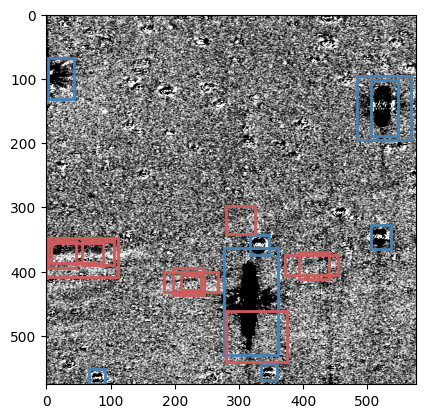

In [90]:
fig, ax = plt.subplots(1, 1)

idx = 0

img = imgs[idx].cpu().numpy();
pred = preds[idx]

ax.imshow(img[0, :,:], cmap='gray', )
for i in range(len(pred['labels'])):
    xmin, ymin, xmax, ymax = pred['boxes'][i].detach().cpu().numpy()
    label = int(pred['labels'][i].cpu())
    score = float(pred['scores'][i].cpu())
    if score>0.5:
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                        fill=False, color=Colors[label], linewidth=2)

        ax.add_patch(rect)


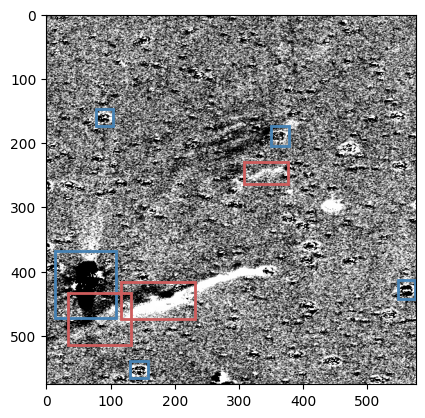

In [92]:
fig, ax = plt.subplots(1, 1)

idx = 1

img = imgs[idx].cpu().numpy();
pred = preds[idx]

ax.imshow(img[0, :,:], cmap='gray', )
for i in range(len(pred['labels'])):
    xmin, ymin, xmax, ymax = pred['boxes'][i].detach().cpu().numpy()
    label = int(pred['labels'][i].cpu())
    score = float(pred['scores'][i].cpu())
    if score>0.8:
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                        fill=False, color=Colors[label], linewidth=2)

        ax.add_patch(rect)


Exercise: how would you define a true positive detection? make a plot of number of TPs/FPs vs score

In [ ]:
#